# B1. GWR at 1ksqm

**Parameters:**

* `dynamic_train_range` = [T1, T2], this is the date range used to train the migration and spatial model. This is [1,365] for rows 2/3 of Figure 3 and [366, 730] for row 4. For Figure 4, this is [366, 365+T] for T=1,...,358.
* `test_range` = [T3, T4], these are the dates to predict/evaluate. For rows 2/3/4 of Figure 3, this is [366, 730].For Figure 4, this is [365+T(+1?), T+7] for T=1,...,358.
* `save_new_prior` = True/False to save the posterior as `_a_app.tif` and `_va_app.tif`, which can then be used as a prior for later runs. Not tested.
* `save_images` to save low-res copies of many maps.
* `prior_type`, specifies the spatial prior as `transect` or `app` (with `app` only available after running the document and saving a new prior).

**Notes:**
* There is internal logic to default to the prior migration model if predicting on a year that is not the same as the training year - this should be checked.
* There are many things we can precompute/save - e.g., posterior detection probabilities, row_to_cell maps, etc.
* We can also save computation by only computing metrics on relevant subsets.
* Models which only operate at the 1ha resolution will be in a new file.

In [2]:
import os
import tqdm
import pickle
import rasterio
from rasterio.windows import Window

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from joblib import Parallel, delayed
from scipy.ndimage import gaussian_filter
from scipy.stats import norm as scipy_norm

from model_utils import *
from spatial_utils import *
from eval_utils import fast_auc

In [3]:
sp_orig = "Spinus spinus"
sp = sp_orig.lower().replace(" ", "_").split(".")[0]

# T0 = end date of 2023
# to train on 2023 and test on 2024:
# dynamic_train_range = [1, 365]
# test_range = [366, 730]
#
# to train on 2024 and test on 2024:
# dynamic_train_range = [366, 730]
# test_range = [366, 730]
#
# to train on part of 2024 and test on next week (careful with overlap?):
# T = 100
# dynamic_train_range = [366, 366+T]
# test_range = [366+T+1, 366+T+7]
T0 = 365
detection_train_range = [1, 365]
dynamic_train_range = [1, 365]
test_range = [366, 730]

prior_type = "transect"
save_new_prior = False
save_images = False

# Detection param prior mean and penalty
beta_prec = 1/100.0
beta_mean =  np.array([-2.0, -2.0, 1.0, 0.0, 0.0])

# Migration functional penalty strength
theta_prec = 1/100.0

# maximum neighborhood size and Gaussian kernel radius
r_nh = 5.0
r_kernel = 2.5

In [4]:
# /data_path/ is a directory with
# - XData.pickle, cleaned metadata
# - migration_prior_params.pickle, data frame of O2 prior migration params
# - /sp/, a subdirectory with
#     - sp_prior.pickle, data frame of prior predictions consistent with XData
#     - sp_a.tif, raster of prior d_a map predictions
#     - sp_va.tif, raster of prior d_a map variance on the probability scale - NOT the linear scale!
# 
# /result_path/ is a directory with
# - /sp/, a subdirectory where all output files are saved (except any new priors, which appear in /data_path/)
path_project = "/scratch/project_2003104/gtikhono/realtime_birds"
dir_data = "data"
dir_results = "results"
path_sp = os.path.join("path_project", dir_data, "species", sp)
path_result = os.path.join("path_project", dir_results, sp)

In [5]:
with open(os.join.path(path_project, dir_data, "XData.pickle"), 'rb') as handle:
    XData = pickle.load(handle)
    
short = (XData["rec_class"] == "short").to_numpy().astype(int)
long = (XData["rec_class"] == "long").to_numpy().astype(int)
point = ((XData["rec_class"]!="short")&(XData["rec_class"]!="long")).to_numpy().astype(int)
log_duration = XData["log_duration"].to_numpy()
lats = XData["lat"].to_numpy()
lons = XData["lon"].to_numpy()
days = XData["j.date"].to_numpy() # in {1,...,730}, but later migration model expects values in {1,...,365}. Use days%365!
ones = np.ones(XData.shape[0])

In [6]:
with open(data_path + "migration_prior_params.pickle", 'rb') as handle:
    prior_m_params = pickle.load(handle)
prior_m_params = prior_m_params.loc[sp][:6].to_numpy()

with open(os.path.join(path_sp, sp+"_prior.pickle"), 'rb') as handle:
    species = pickle.load(handle)

species["prior.s.L"] = pd.Series(scipy_norm.ppf(species["prior.s"]), index=species["prior.s"].index)
if species["prior.s.L"].isna().any() or species["prior.s.L"].isin([np.inf, -np.inf]).any():
    print("NaNs or infs introduced when mapping s -> \Phi^{-1}(s)")
    
y = species["y"].to_numpy()
prior_s = species["prior.s"].to_numpy()
prior_d_b = species["prior.d.b"].to_numpy()
prior_d_transect = species["prior.d"].to_numpy()
prior_m = species["prior.m"].to_numpy()
prior_sL = species["prior.s.L"].to_numpy()
u = (species["prior.d.u"]==0).to_numpy()
complete = species["complete"].to_numpy()

detection_train_idx = complete*(detection_train_range[0] <= days)*(days <= detection_train_range[1])
dynamic_train_idx = complete*(dynamic_train_range[0] <= days)*(days <= dynamic_train_range[1])
test_idx = complete*(test_range[0] <= days)*(days <= test_range[1])
actual_prev = y[test_idx].sum()

In [7]:
prior_preds = prior_m*prior_s*prior_d_transect
prior_AUC = fast_auc(y[test_idx], prior_preds[test_idx])
prior_R2 = prior_preds[(y==1)*test_idx].mean() - prior_preds[(y==0)*test_idx].mean()
print("Prior AUC (2024):", np.round(prior_AUC,3))
print("Prior R2 (2024):", np.round(prior_R2,3))

Prior AUC (2024): 0.583
Prior R2 (2024): 0.039


In [8]:
if prior_type == "transect":
    path_a = os.path.join(path_sp, sp+"_a.tif")
    path_va = os.path.join(path_sp, sp+"_va.tif")
elif prior_type == "app":
    path_a = os.path.join(path_sp, sp+"_a_app.tif")
    path_va = os.path.join(path_sp, sp+"_va_app.tif")

factor = 10 
with rasterio.open(path_a) as src:
    height_ha, width_ha = src.height, src.width
    transform_ha = src.transform
    height_km = height_ha//factor
    width_km = width_ha//factor
    window = Window(0, 0, width_km*factor, height_km*factor)
    a_ha = src.read(1, window=window)
    height_ha, width_ha = a_ha.shape
    transform_ha = src.window_transform(window) 
    profile = src.profile
    profile.update({"height": height_ha, "width": width_ha,
                    "transform": transform_ha, "nodata": np.nan})

with rasterio.open(path_va) as src:
    va_ha = src.read(1, window=window)
va_ha[(np.isnan(va_ha))&(~np.isnan(a_ha))] = 1.0 # ensure a_map != nan implies va_map != nan
va_ha[np.isnan(a_ha)] = np.nan
va_ha = np.clip(va_ha, 1e-4, 1) # clip very small variances to avoid numerical issues with precision

a_km = a_ha.copy()
a_km = a_km.reshape(height_km, factor, width_km, factor)
a_km = np.nanmean(a_km, axis=(1, 3))
va_km = va_ha.copy()
va_km = va_km.reshape(height_km, factor, width_km, factor)
va_km = np.nanmean(va_km, axis=(1, 3))
transform_km = transform_ha*transform_ha.scale(factor, factor)

# extract grids
ys_km = np.arange(height_km)
_, lat_grid_km = rasterio.transform.xy(transform_km, ys_km, np.zeros_like(ys_km))
lat_grid_km = np.array(lat_grid_km)
xs_km = np.arange(width_km)
lon_grid_km, _ = rasterio.transform.xy(transform_km, np.zeros_like(xs_km), xs_km)
lon_grid_km = np.array(lon_grid_km)

ys_ha = np.arange(height_ha)
_, lat_grid_ha = rasterio.transform.xy(transform_ha, ys_ha, np.zeros_like(ys_ha))
lat_grid_ha = np.array(lat_grid_ha)
xs_ha = np.arange(width_ha)
lon_grid_ha, _ = rasterio.transform.xy(transform_ha, np.zeros_like(xs_ha), xs_ha)
lon_grid_ha = np.array(lon_grid_ha)

lat_min, lat_max = max(lat_grid_ha[-1], lat_grid_km[-1]), min(lat_grid_ha[0], lat_grid_km[0]) 
lon_min, lon_max = max(lon_grid_ha[0], lon_grid_km[0]), min(lon_grid_ha[-1], lon_grid_km[-1])
lons_clipped = lons.clip(lon_min, lon_max)
lats_clipped = lats.clip(lat_min, lat_max)

cell_idx = np.arange(height_km*width_km).reshape(height_km, width_km)
rows_to_grid = rasterio.transform.rowcol(transform_km, lons_clipped, lats_clipped)
rows_to_idx = cell_idx[rows_to_grid]

cell_idx_ha = np.arange(height_ha*width_ha).reshape(height_ha, width_ha)
rows_to_grid_ha = rasterio.transform.rowcol(transform_ha, lons_clipped, lats_clipped)
rows_to_idx_ha = cell_idx_ha[rows_to_grid_ha]

prior_d_a = a_ha.flatten()[rows_to_idx_ha]
prior_d = prior_d_a + (1-prior_d_a)*u*prior_d_b

<ipython-input-8-67dc8feb9037>:30: RuntimeWarning: Mean of empty slice
  a_km = np.nanmean(a_km, axis=(1, 3))
<ipython-input-8-67dc8feb9037>:33: RuntimeWarning: Mean of empty slice
  va_km = np.nanmean(va_km, axis=(1, 3))
<ipython-input-8-67dc8feb9037>:65: RuntimeWarning: invalid value encountered in multiply
  prior_d = prior_d_a + (1-prior_d_a)*u*prior_d_b


In [9]:
tau_detection = prior_m*prior_d
X_detection = np.c_[ones*short, ones*long, prior_sL, short*log_duration, long*log_duration, point]
beta = fit_detection_model(y[detection_train_idx], X_detection[detection_train_idx,:5], 
                           tau_detection[detection_train_idx,], beta_mean, beta_prec)
point_intercept = (beta[0] + beta[1] + (beta[3] + beta[4])*np.log(300))/2 # irrelevant for 2023 but needed for 2024
beta = np.append(beta, point_intercept)
post_s = scipy_norm.cdf(X_detection@beta)

post_detection = post_s*tau_detection
detection_AUC = fast_auc(y[test_idx], post_detection[test_idx])
detection_R2 = post_detection[(y==1)*test_idx].mean() - post_detection[(y==0)*test_idx].mean()
print("AUC after updating detection (out-of-sample):", np.round(detection_AUC,3))
print("R2 after updating detection (out-of-sample):", np.round(detection_R2,3))

Training detection model:   2%|▏         | 199/10000 [00:07<06:25, 25.45it/s]


AUC after updating detection (out-of-sample): 0.722
R2 after updating detection (out-of-sample): 0.031


In [10]:
if np.var(prior_m) == 0:
    print("Migration model has no variance; skipping resident species.")
    post_m = prior_m
    theta = prior_m_params
else:
    tau_migration = post_s*prior_d
    theta = fit_migration_model(y[dynamic_train_idx], lats[dynamic_train_idx], 
                                days[dynamic_train_idx]%365, tau_migration[dynamic_train_idx], 
                                prior_m_params, theta_prec)
    post_m = m_numpy(lats, days%365, theta)

    post_migration = post_m*tau_migration
    
suffix = "_migration_"+"_".join([str(T) for T in dynamic_train_range])+".npy"
np.save(os.path.join(path_project, dir_result, sp, sp+suffix), theta)

Training migration model:   2%|▏         | 199/10000 [00:09<07:31, 21.73it/s]


In [11]:
# test_lats = [60, 65, 70]
# test_days = range(1, 365)
# fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
# for i, test_lat in enumerate(test_lats):
#     m_func_prior = m_numpy(test_lat, test_days, prior_m_params)
#     m_func_post = m_numpy(test_lat, test_days, theta)
#     ax[i].plot(test_days, m_func_prior, color="blue", label="Prior");
#     ax[i].plot(test_days, m_func_post, color="red", label="Posterior");
#     ax[i].set_title("(lat = " + str(test_lat) + ")");
#     ax[i].legend(loc="upper right")
#     ax[i].set_xlabel("Day")
#     ax[i].axvline(90, color="grey", linestyle="dashed", linewidth=1)
#     ax[i].axvline(180, color="grey", linestyle="dashed", linewidth=1)
#     ax[i].axvline(270, color="grey", linestyle="dashed", linewidth=1)
# plt.suptitle("Updated migration model for " + sp);
# plt.tight_layout()

In [12]:
prior_map = DistributionMap(cell_idx=cell_idx, lat_grid=lat_grid_km, lon_grid=lon_grid_km,
                           mean_map=a_km, var_map=va_km)
post_map = DistributionMap(cell_idx=cell_idx, lat_grid=lat_grid_km, lon_grid=lon_grid_km,
                          mean_map=a_km.copy(), var_map=va_km.copy())
prior_ha_mean = a_ha.copy()
post_ha_mean = a_ha.copy()

cells_with_data = np.unique(rows_to_idx[dynamic_train_idx])
cells_to_update = set()
for c in tqdm.tqdm(cells_with_data):
    cells_to_update.update(prior_map.get_nearby_cells(c, r_nh))
cells_to_update = np.array(list(cells_to_update)) 
print("Fraction of cells to update:", np.round(len(cells_to_update)/len(a_km[~np.isnan(a_km)]),2))

100%|██████████| 111495/111495 [00:03<00:00, 28999.44it/s]

Fraction of cells to update: 0.94


In [13]:
Y_dict = {}
threshold_dict = {}
has_data = np.zeros([prior_map.height, prior_map.width]).astype(bool)

tau_spatial = post_s*post_m
d_train_idx = dynamic_train_idx*u
rows_to_idx_obs, y_obs, tau_spatial_obs = rows_to_idx[d_train_idx], y[d_train_idx], tau_spatial[d_train_idx]
cells_with_data, unique_inverse, unique_counts = np.unique(rows_to_idx_obs, return_inverse=True, return_counts=True)

ord0 = np.argsort(cells_with_data)
ord1 = np.argsort(unique_inverse)
sel_list = np.split(ord1, np.cumsum(unique_counts[ord0])[:-1])
has_data[cells_with_data//prior_map.width, cells_with_data%prior_map.width] = True

for c, sel in zip(tqdm.tqdm(cells_with_data, position=0, leave=True), sel_list):
    Y_dict[c], threshold_dict[c] = y_obs[sel], tau_spatial_obs[sel]
    
has_data = has_data.flatten()
data_map = DataMap(Y_dict = Y_dict, threshold_dict = threshold_dict, has_data = has_data)

100%|██████████| 111495/111495 [00:00<00:00, 395041.93it/s]


In [14]:
def fit_spatial(cArray):
    m, v = [np.zeros(len(cArray)) for i in range(2)]
    for i, c0 in enumerate(tqdm.tqdm(cArray, position=0, leave=True, desc="Fitting spatial model")):
        row = c0//prior_map.width
        col = c0%prior_map.width
        prior_mean = prior_map.mean_map[row, col]
        prior_prec = 1/prior_map.var_map[row, col] # convert to precision
        neighborhood = prior_map.get_nearby_cells(c0, r_nh)
        cells_to_use = neighborhood[data_map.has_data[neighborhood]]
        if len(cells_to_use) == 0:
            m[i], v[i] = prior_map.mean_map[row, col], prior_map.var_map[row, col]
        else:
            Y_train, n_train, threshold_train = data_map.pool_data(cells_to_use)
            cell_weights = prior_map.calculate_kernel(c0, cells_to_use, r_kernel)    
            weights_train = np.repeat(cell_weights, n_train)
            result = fit_GWR(Y_train, threshold_train, weights_train, prior_mean, prior_prec)
            m[i], v[i] = result["mean"], result["variance"]
    return m, v

jn = 8
cell_to_update_list = [cells_to_update[i::jn] for i in range(jn)]
results = Parallel(n_jobs=jn)(delayed(fit_spatial)(c0) for c0 in cell_to_update_list)

origInd = np.argsort(np.concatenate([np.arange(len(cv))*jn+i for i,cv in enumerate(cell_to_update_list)]))
ma = np.concatenate([res[0] for res in results])[origInd]
va = np.concatenate([res[1] for res in results])[origInd]
post_map.mean_map[cells_to_update//prior_map.width, cells_to_update%prior_map.width] = ma
post_map.var_map[cells_to_update//prior_map.width, cells_to_update%prior_map.width] = va

In [15]:
#same_year = (dynamic_train_range[1] - 1)//365 == (test_range[0] - 1)//365
same_year = (dynamic_train_range[1]>365) == (test_range[0]>365)
if same_year:
    m_pred = post_m
else: 
    m_pred = prior_m

post_d_a_km = post_map.mean_map.flatten()[rows_to_idx]
post_d_km = post_d_a_km + (1-post_d_a_km)*u*prior_d_b
post_spatial_km = post_s*m_pred*post_d_km
spatial_AUC_km = fast_auc(y[test_idx], post_spatial_km[test_idx])
print("AUC after updating spatial (out-of-sample, 1km):", np.round(spatial_AUC_km,3))

<ipython-input-15-c50b6a02ebb0>:9: RuntimeWarning: invalid value encountered in multiply
  post_d_km = post_d_a_km + (1-post_d_a_km)*u*prior_d_b


AUC after updating spatial (out-of-sample, 1km): 0.734


# Code below needs to be parallelized/vectorized

In [16]:
def shift_loss(delta, avg, Ls):
    probs_shifted = scipy_norm.cdf(Ls + delta)
    return np.square(avg - np.mean(probs_shifted))

for c0 in tqdm.tqdm(cells_to_update):
    row = c0//prior_map.width
    col = c0%prior_map.width
    prob_grid = prior_ha_mean[(factor*row):(factor*(row+1)),(factor*col):(factor*(col+1))]
    prob_vec = prob_grid[~np.isnan(prob_grid)]
    L_vec = scipy_norm.ppf(prob_vec)
    result = minimize_scalar(shift_loss, args=(post_map.mean_map[row, col], L_vec))
    delta = result.x
    prob_grid_shifted = scipy_norm.cdf(scipy_norm.ppf(prob_grid) + delta)
    post_ha_mean[(factor*row):(factor*(row+1)),(factor*col):(factor*(col+1))] = prob_grid_shifted
    
post_ha_var = va_ha.copy()
for c0 in tqdm.tqdm(cells_to_update):
    row = c0//prior_map.width
    col = c0%prior_map.width
    post_ha_var[(factor*row):(factor*(row+1)),(factor*col):(factor*(col+1))] = post_map.var_map[row, col]

100%|██████████| 316451/316451 [00:00<00:00, 571363.01it/s]


In [21]:
if save_new_prior:
    with rasterio.open(os.path.join(path_sp, sp+"_a_app.tif"), "w", **profile) as dst:
        dst.write(post_ha_mean, 1)
    with rasterio.open(os.path.join(path_sp, sp+"_va_app.tif"), "w", **profile) as dst:
        dst.write(post_ha_var, 1)

In [22]:
post_d_a_ha = post_ha_mean.flatten()[rows_to_idx_ha]
post_d_ha = post_d_a_ha + (1-post_d_a_ha)*u*prior_d_b
post_spatial_ha = post_s*m_pred*post_d_ha
spatial_AUC_ha = fast_auc(y[test_idx], post_spatial_ha[test_idx])
print("AUC after updating detection (out-of-sample, 1ha):", np.round(spatial_AUC_ha,3))

<ipython-input-22-0cd0136d6c9f>:2: RuntimeWarning: invalid value encountered in multiply
  post_d_ha = post_d_a_ha + (1-post_d_a_ha)*u*prior_d_b


AUC after updating detection (out-of-sample, 1ha): 0.722


In [23]:
def llh(ys, probs):
    probs_clipped = np.clip(probs, 1e-6, 1-1e-6)
    return ys*np.log(probs_clipped) + (1-ys)*np.log(1-probs_clipped)

AUCs = {}
AUCs["prior"] = fast_auc(y[test_idx], prior_preds[test_idx])
AUCs["detection"] = fast_auc(y[test_idx], post_detection[test_idx])
AUCs["GWR_1km"] = fast_auc(y[test_idx], post_spatial_km[test_idx])
AUCs["GWR_1ha"] = fast_auc(y[test_idx], post_spatial_ha[test_idx])

R2s = {}
R2s["prior"] =  prior_preds[(y==1)*test_idx].mean() - prior_preds[(y==0)*test_idx].mean()
R2s["detection"] = post_detection[(y==1)*test_idx].mean() - post_detection[(y==0)*test_idx].mean()
R2s["GWR_1km"] = post_spatial_km[(y==1)*test_idx].mean() - post_spatial_km[(y==0)*test_idx].mean()
R2s["GWR_1ha"] = post_spatial_ha[(y==1)*test_idx].mean() - post_spatial_ha[(y==0)*test_idx].mean()

prevs = {}
prevs["actual"] = y[test_idx].sum()
prevs["detection"] = post_detection[test_idx].sum()
prevs["GWR_1km"] = post_spatial_km[test_idx].sum()
prevs["GWR_1ha"] = post_spatial_ha[test_idx].sum()

llhs = {}
llhs["prior"] = llh(y[test_idx], prior_preds[test_idx]).mean()
llhs["detection"] = llh(y[test_idx], post_detection[test_idx]).mean()
llhs["GWR_1km"] = llh(y[test_idx], post_spatial_km[test_idx]).mean()
llhs["GWR_1ha"] = llh(y[test_idx], post_spatial_ha[test_idx]).mean()

output = {}
output["AUCs"] = AUCs
output["R2s"] = R2s
output["prevs"] = prevs
output["llhs"] = llhs

suffix = "_".join([str(T) for T in dynamic_train_range+test_range])
with open(os.path.join(path_result, sp+"_evals_"+suffix+".pickle"), "wb") as handle:
    pickle.dump(output, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
final_preds = np.c_[y[test_idx], post_s[test_idx], m_pred[test_idx], post_d_km[test_idx], post_d_ha[test_idx]]
np.save(os.path.join(path_result, sp+"_preds_"+suffix+".npy"), final_preds)

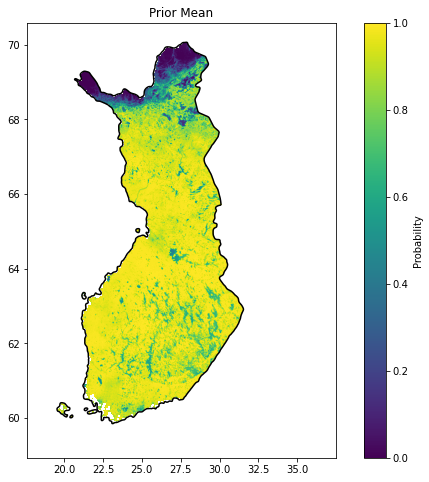

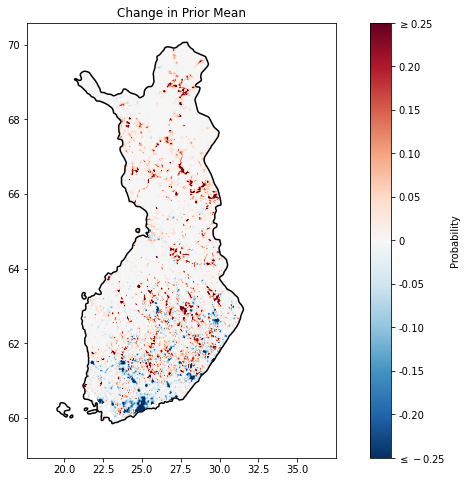

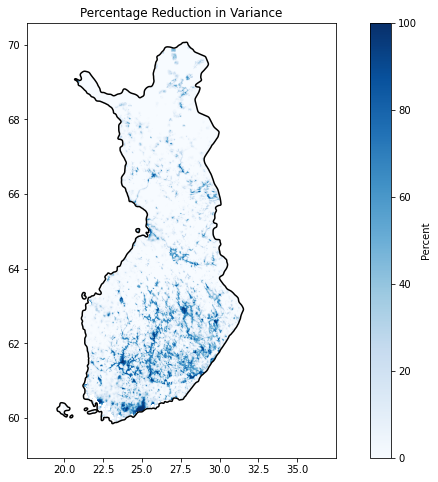

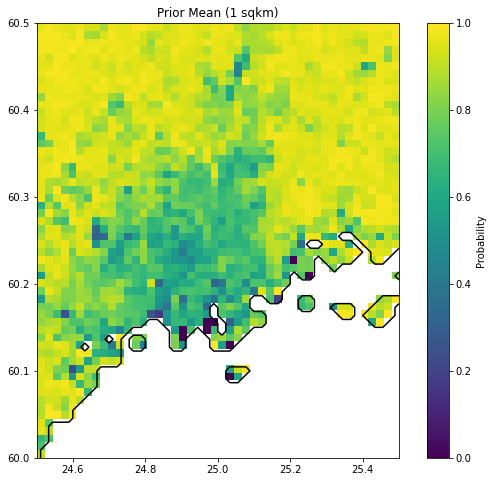

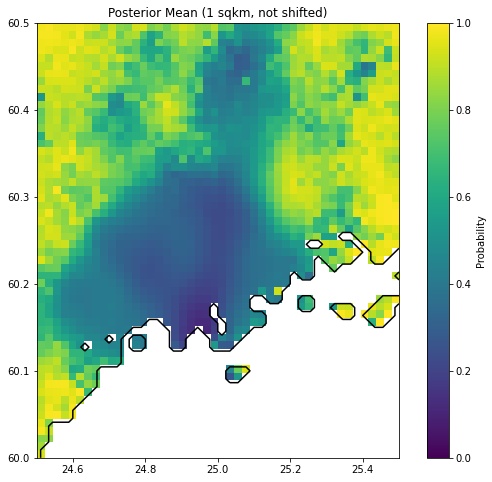

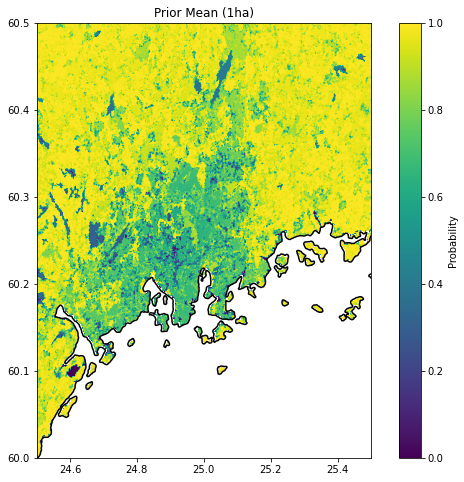

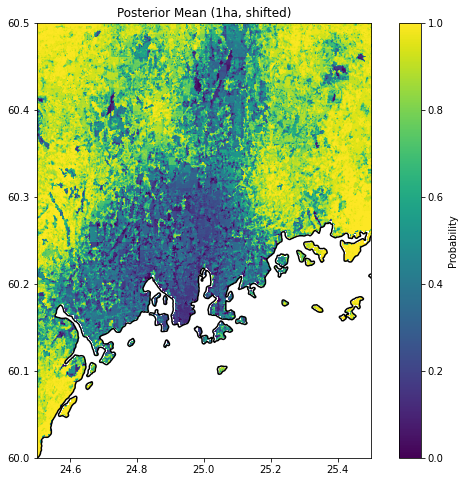

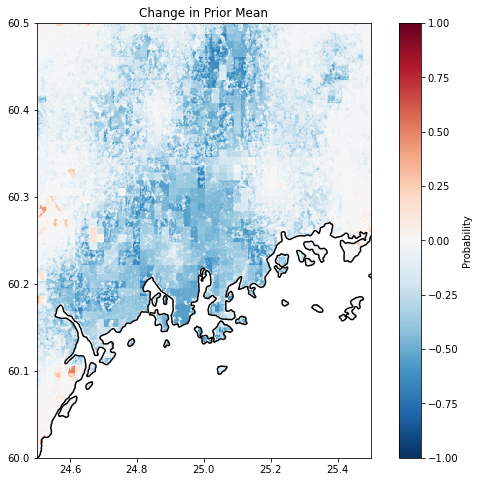

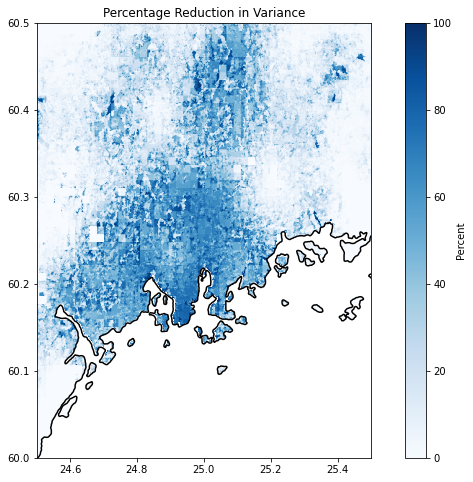

In [25]:
if save_images:
    suffix = "_".join([str(T) for T in dynamic_train_range]) + ".jpeg"
    
    mask = ~np.isnan(prior_map.mean_map)
    smoothed_mask = gaussian_filter(mask.astype(float), sigma=3)  
    bounds = [lon_grid_km.min(), lon_grid_km.max(), lat_grid_km.min(), lat_grid_km.max()]

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(prior_map.mean_map, vmin=0, vmax=1, cmap="viridis", extent = bounds)
    ax.contour(smoothed_mask[::-1,:], levels=[0.75], colors="black", linewidths=1.5, extent = bounds) 
    ax.set_aspect(2.4)
    fig.colorbar(im, ax=ax, label="Probability")
    ax.set_title("Prior Mean");
    plt.savefig(os.path.join(path_result, sp+"_prior_"+suffix))
    
    delta_mean = post_map.mean_map - prior_map.mean_map
    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(delta_mean, cmap="RdBu_r", vmin=-0.25, vmax=0.25, extent = bounds)
    ax.contour(smoothed_mask[::-1,:], levels=[0.75], colors="black", linewidths=1.5, extent = bounds) 
    ax.set_aspect(2.4)
    cbar = fig.colorbar(im, ax=ax, label="Probability")
    cbar.set_ticks([-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25])
    cbar.set_ticklabels([r"$\leq -0.25$", "-0.20", "-0.15", "-0.10", "-0.05", "0", "0.05", "0.10", "0.15", "0.20", r"$\geq 0.25$"])
    ax.set_title("Change in Prior Mean");
    plt.savefig(os.path.join(path_result, sp+"_delta_prior_"+suffix))
    
    ratio_var = 100*(1-post_map.var_map/prior_map.var_map)
    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(ratio_var, cmap="Blues", vmin=0, vmax=100, extent=bounds)
    ax.contour(smoothed_mask[::-1,:], levels=[0.75], colors="black", linewidths=1.5, extent = bounds) 
    ax.set_aspect(2.4)
    cbar = fig.colorbar(im, ax=ax, label="Percent")
    ax.set_title("Percentage Reduction in Variance");
    plt.savefig(os.path.join(path_result, sp+"_delta_var_"+suffix))
    
    bounds = [24.5, 25.5, 60, 60.5]
    lat_min_hel_idx = binary_search_dec(lat_grid_km, 60)
    lat_max_hel_idx = binary_search_dec(lat_grid_km, 60.5)
    lon_min_hel_idx = binary_search_inc(lon_grid_km, 24.5)
    lon_max_hel_idx = binary_search_inc(lon_grid_km, 25.5)

    prior_hel_km = prior_map.mean_map[lat_max_hel_idx:lat_min_hel_idx, lon_min_hel_idx:lon_max_hel_idx]
    mask_hel_km = ~np.isnan(prior_hel_km)
    mask_hel_km = gaussian_filter(mask_hel_km.astype(float), sigma=0.1)  

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(prior_hel_km, vmin=0, vmax=1, cmap="viridis", extent = bounds) 
    ax.contour(mask_hel_km[::-1,:], levels=[0.5], colors="black", linewidths=1.5, extent = bounds) 
    ax.set_aspect(2.4)
    fig.colorbar(im, ax=ax, label="Probability")
    ax.set_title("Prior Mean (1 sqkm)");
    plt.savefig(os.path.join(path_result, sp+"_prior_hel_km_"+suffix))
    
    post_hel_km = post_map.mean_map[lat_max_hel_idx:lat_min_hel_idx, lon_min_hel_idx:lon_max_hel_idx]
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(post_hel_km, vmin=0, vmax=1, cmap="viridis", extent = bounds) 
    ax.contour(mask_hel_km[::-1,:], levels=[0.5], colors="black", linewidths=1.5, extent = bounds) 
    ax.set_aspect(2.4)
    fig.colorbar(im, ax=ax, label="Probability")
    ax.set_title("Posterior Mean (1 sqkm, not shifted)");
    plt.savefig(os.path.join(path_result, sp+"_post_hel_km_"+suffix))
    
    bounds = [24.5, 25.5, 60, 60.5]
    lat_min_hel_idx = binary_search_dec(lat_grid_ha, 60)
    lat_max_hel_idx = binary_search_dec(lat_grid_ha, 60.5)
    lon_min_hel_idx = binary_search_inc(lon_grid_ha, 24.5)
    lon_max_hel_idx = binary_search_inc(lon_grid_ha, 25.5)

    prior_hel_ha = prior_ha_mean[lat_max_hel_idx:lat_min_hel_idx, lon_min_hel_idx:lon_max_hel_idx]
    mask_hel_ha = ~np.isnan(prior_hel_ha)
    mask_hel_ha = gaussian_filter(mask_hel_ha.astype(float), sigma=1)  

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(prior_hel_ha, vmin=0, vmax=1, cmap="viridis", extent = bounds)
    ax.contour(mask_hel_ha[::-1,:], levels=[0.5], colors="black", linewidths=1.5, extent = bounds) 
    ax.set_aspect(2.6)
    fig.colorbar(im, ax=ax, label="Probability")
    ax.set_title("Prior Mean (1ha)");
    plt.savefig(os.path.join(path_result, sp+"_prior_hel_ha_"+suffix))
    
    post_hel_ha = post_ha_mean[lat_max_hel_idx:lat_min_hel_idx, lon_min_hel_idx:lon_max_hel_idx]
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(post_hel_ha, vmin=0, vmax=1, cmap="viridis", extent = bounds)
    ax.contour(mask_hel_ha[::-1,:], levels=[0.5], colors="black", linewidths=1.5, extent = bounds) 
    ax.set_aspect(2.6)
    fig.colorbar(im, ax=ax, label="Probability")
    ax.set_title("Posterior Mean (1ha, shifted)");
    plt.savefig(os.path.join(path_result, sp+"_post_hel_ha_"+suffix))
    
    delta_hel_ha = post_hel_ha - prior_hel_ha
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(delta_hel_ha, cmap="RdBu_r", vmin=-1, vmax=1, extent = bounds)
    ax.contour(mask_hel_ha[::-1,:], levels=[0.5], colors="black", linewidths=1.5, extent = bounds) 
    ax.set_aspect(2.6)
    cbar = fig.colorbar(im, ax=ax, label="Probability")
    ax.set_title("Change in Prior Mean");
    plt.savefig(os.path.join(path_result, sp+"_delta_prior_ha_"+suffix))
    
    ratio_hel_ha = 100*(1-post_hel_ha/prior_hel_ha)
    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(ratio_hel_ha, cmap="Blues", vmin=0, vmax=100, extent=bounds)
    ax.contour(mask_hel_ha[::-1,:], levels=[0.5], colors="black", linewidths=1.5, extent = bounds) 
    ax.set_aspect(2.6)
    cbar = fig.colorbar(im, ax=ax, label="Percent")
    ax.set_title("Percentage Reduction in Variance");
    plt.savefig(os.path.join(path_result, sp+"_delta_var_ha_"+suffix))